In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import math

In [2]:
lf = 3
pkl_file = open(f'../data/cat{lf}.pkl', 'rb')

data = pickle.load(pkl_file)
pkl_file.close()
data.shape

(794, 90000, 3)

In [3]:
image_chop = 15
data = data.reshape(int(data.shape[0] * image_chop), int(data.shape[1] / image_chop), 3)
data.shape

(11910, 6000, 3)

In [4]:
device = torch.device('cuda:0')

In [5]:
x = torch.tensor(data, dtype=torch.float32, device=device)

In [6]:
x.shape

torch.Size([11910, 6000, 3])

In [7]:
# params
N = x.shape[0]
D_in = x.shape[1]
H1 = 3000
D_out = 900

learning_rate = 0.001
batch_size = image_chop * 100
epochs = 200

# Regularisierung
weight_decay=0.001

In [8]:
# Neural Network
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            nn.Linear(D_in, H1),
            nn.ReLU(),
            nn.Linear(H1, D_out)
        )

        self.decoder = torch.nn.Sequential(
            nn.Linear(D_out, H1),
            nn.ReLU(),
            nn.Linear(H1, D_in),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
model = autoencoder().cuda()

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

In [11]:
# Train
loss_hist = []
for t in range(epochs):
    for batch in range(0, int(N/batch_size)):
        # Berechne den Batch
        batch_x = x[batch * batch_size : (batch + 1) * batch_size, :].transpose(1, 2)
        
        # Berechne die Vorhersage (foward step)
        outputs = model.forward(batch_x)
        
        # Berechne den Fehler
        loss = criterion(outputs, batch_x)
        
        # Berechne die Gradienten und Aktualisiere die Gewichte (backward step)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Berechne den Fehler (Ausgabe des Fehlers alle x Iterationen)
    if t % 5 == 0:
        loss_hist.append(loss.item())
        print(t, loss.item())

0 0.14345239102840424
5 0.32951003313064575
10 0.31159135699272156
15 0.3093957304954529
20 0.26720523834228516
25 0.2977370023727417
30 0.09149613976478577
35 0.14989641308784485
40 0.34321674704551697
45 0.33934372663497925
50 0.3356911838054657
55 0.32677870988845825
60 0.11002571880817413
65 0.2136235386133194
70 0.33636313676834106
75 0.3491259515285492
80 0.29821398854255676
85 0.3552260398864746
90 0.3541448414325714
95 0.35278981924057007
100 0.3494958281517029
105 0.3142120838165283
110 0.3091026544570923
115 0.323844850063324
120 0.2232712209224701
125 0.34935852885246277
130 0.33290818333625793
135 0.32881003618240356
140 0.30296313762664795
145 0.11596310883760452
150 0.3473743796348572
155 0.35706040263175964
160 0.35853034257888794
165 0.2939585745334625
170 0.3537668287754059
175 0.34583941102027893
180 0.3507217764854431
185 0.3349536657333374
190 0.3433506190776825
195 0.35242077708244324


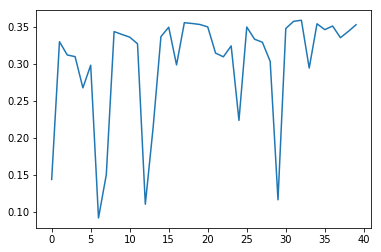

In [12]:
plt.plot(loss_hist)